# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, sum, count, when, isnull,countDistinct
from pyspark.sql import Window

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.sql.types import IntegerType, FloatType

import numpy as np
import pandas as pd
import matplotlib.pyplot as ml
import seaborn as sns
%matplotlib inline

import plotly.offline as plt
plt.init_notebook_mode(connected=True)
import plotly.plotly as py
import plotly.graph_objs as go

import datetime

import warnings
warnings.filterwarnings("ignore")

# Load and Clean Dataset

Load and clean the dataset, checking for invalid or missing data. 

In [2]:
# create a Spark session
spark = SparkSession \
        .builder \
        .appName("Predict Customer Churn") \
        .getOrCreate()

In [3]:
path = 'mini_sparkify_event_data.json'
user_log = spark.read.json(path)
user_log.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [4]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



# Exploratory Data Analysis

In [5]:
# Check for missing values 
user_log.select([count(when(isnull(c), c)).alias(c) for c in user_log.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [6]:
# exploring missing values in columns: firstName, gender, lastName, location, registration, user_agent
user_log.filter(user_log["firstName"].isNull()).select("page").distinct().show()

+-------------------+
|               page|
+-------------------+
|               Home|
|              About|
|Submit Registration|
|              Login|
|           Register|
|               Help|
|              Error|
+-------------------+



In [7]:
user_log.filter(user_log["location"].isNull()).select("page").distinct().show()

+-------------------+
|               page|
+-------------------+
|               Home|
|              About|
|Submit Registration|
|              Login|
|           Register|
|               Help|
|              Error|
+-------------------+



We can observe from above that the columns: firstName, lastName, location, registration, gender, user_agent are empty only in cases where the user is on pages : Home, About etc. It is probably in the case, when user is either logged out or hasn't signed up yet.

In [8]:
# dropping rows that contain null values for userId and sessionId
user_log_valid = user_log.dropna(how="any", subset=["userId","sessionId"])

In [9]:
user_log_valid.count()

286500

We can see that the number of rows are the same . It is due to missing userId is represented using empty string.

In [10]:
user_log_valid.filter(user_log["userId"]=="").select("page").distinct().show()

+-------------------+
|               page|
+-------------------+
|               Home|
|              About|
|Submit Registration|
|              Login|
|           Register|
|               Help|
|              Error|
+-------------------+



In [11]:
user_log_valid.filter(user_log["userId"]=="").select("auth").distinct().show()

+----------+
|      auth|
+----------+
|Logged Out|
|     Guest|
+----------+



The rows with userId represented by empty string will help little in our analysis, so we can remove them. 

In [12]:
user_log_valid = user_log_valid.filter(user_log_valid["userId"] != "")
user_log_valid.count()

278154

In [13]:
# exploring missing values in columns : artist, length, song
user_log_valid.where(user_log["artist"].isNull()).select("page").distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [14]:
user_log_valid.where(user_log["artist"].isNotNull()).select("page").distinct().show()

+--------+
|    page|
+--------+
|NextSong|
+--------+



We can see that the artist column is null , only in cases where the page visited is not "Next page". Thus, we can conclude that whenever a user is not listening to a song, the columns- artist, song and length are null.

In [15]:
#  different types of authorisation
user_log_valid.select("auth").distinct().show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [16]:
# different types of levels

user_log_valid.select("level").distinct().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [17]:
user_log_valid.select("method").distinct().show()

+------+
|method|
+------+
|   PUT|
|   GET|
+------+



In [18]:
# different types of gender
user_log_valid.select("gender").distinct().show()

+------+
|gender|
+------+
|     F|
|     M|
+------+



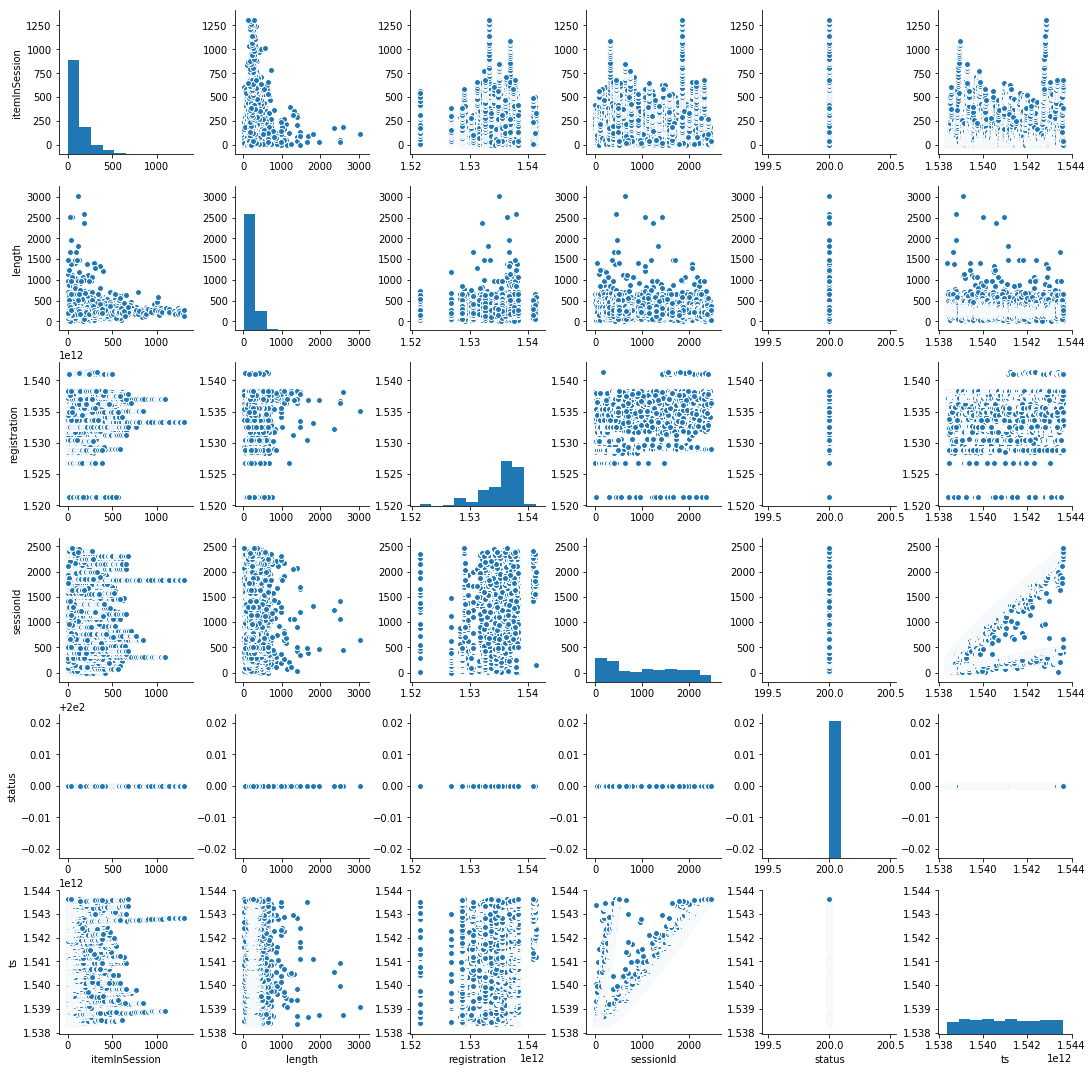

In [19]:
# correlation between various features , using a sample of data
sample_user_log = user_log_valid.sample(withReplacement=False, fraction=0.1).toPandas()
sample_user_log = sample_user_log.select_dtypes(include=['int64','float64'])
sample_user_log = sample_user_log.dropna()
sns.pairplot(sample_user_log)

From the pairplot above, we can observe that there are a number of correlated features : ts and sessionId.We should be mindful of this. Keeping them both will not help much in our analysis.

### explore users who churned and who didn't churn

In [20]:
# Defining udf to flag Churn
churn = udf(lambda x :1 if x =='Cancellation Confirmation' else 0, IntegerType())

In [21]:
# label users who churned
windowval = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)

user_log_valid = user_log_valid.withColumn("churned", churn("page"))
user_log_valid = user_log_valid.withColumn("churned", sum("churned").over(windowval))

In [22]:
# adjusting timestamp to proper understandable format
convert_time = udf(lambda x : datetime.datetime.utcfromtimestamp(x/1000).strftime('%Y-%m-%d %H:%M:%S'))

In [23]:
# creating columns with the new timestamp format
user_log_valid = user_log_valid.withColumn('log_time', convert_time('ts'))
user_log_valid = user_log_valid.withColumn('registration_time', convert_time('registration'))

In [24]:
user_log_valid.take(2)

[Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churned=0, log_time='2018-10-08 12:58:54', registration_time='2018-09-27 02:45:40'),
 Row(artist='Francesca Battistelli', auth='Logged In', firstName='Darianna', gender='F', itemInSession=1, lastName='Carpenter', length=196.54485, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Beautiful_ Beautiful (Album)', status=200, ts=1539003736000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone O

In [25]:
# percent of churned users
user_log_valid.filter(user_log_valid['churned']==1).select('userId').distinct().count()/user_log_valid.select('userId')\
        .distinct().count() * 100

23.11111111111111

In [26]:
# percent of non-churned users
user_log_valid.filter(user_log_valid['churned']==0).select('userId').distinct().count()/user_log_valid.select('userId').distinct().count() * 100

76.88888888888889

### gender distribution of customer churn

In [27]:
gender_churn_df = user_log_valid.select(["userId","gender", "churned"]).dropDuplicates().\
                    groupby(["churned"]).pivot("gender").agg(count("userId")).toPandas()
gender_churn_df

,churned,F,M
0,0,84,89
1,1,20,32


In [28]:
trace1 = go.Bar(
    x=gender_churn_df["churned"],
    y=gender_churn_df["F"],
    name = "Female"
)
trace2 = go.Bar(
    x=gender_churn_df["churned"],
    y= gender_churn_df["M"],
    name = "Male"
)
layout = go.Layout(title="Gender wise distribution of customer churn")
data = [trace1,trace2]

figure = go.Figure(data=data, layout=layout)
plt.iplot(figure)

From above plot, we can observe that Males are more likely to churn.

In [29]:
user_log_valid.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId',
 'churned',
 'log_time',
 'registration_time']

Text(0.5,1,'Count of churned and non-churned by levels')

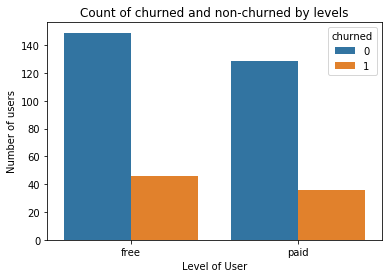

In [30]:
# Visualising churn counts by level of Users
level_churn_df = user_log_valid.select('userId','level','churned').dropDuplicates().toPandas()
sns.countplot(x='level',hue='churned',data=level_churn_df)
ml.xlabel("Level of User")
ml.ylabel("Number of users")
ml.title("Count of churned and non-churned by levels")

In [31]:
# pivot table displaying number of page events per user
df_page = user_log_valid.groupby("userId","churned").pivot("page").count().fillna(0).toPandas()
df_page.head()

,userId,churned,About,Add Friend,Add to Playlist,Cancel,Cancellation Confirmation,Downgrade,Error,Help,...,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,100010,0,1,4,7,0,0,0,0,2,...,5,275,52,0,0,0,0,5,17,2
1,200002,0,3,4,8,0,0,5,0,2,...,5,387,7,0,3,0,1,6,21,2
2,125,1,0,0,0,1,1,0,0,0,...,0,8,1,0,0,0,0,0,0,0
3,124,0,7,74,118,0,0,41,6,23,...,59,4079,4,6,20,0,0,41,171,0
4,51,1,2,28,52,1,1,23,1,12,...,24,2111,0,1,12,0,0,21,100,0


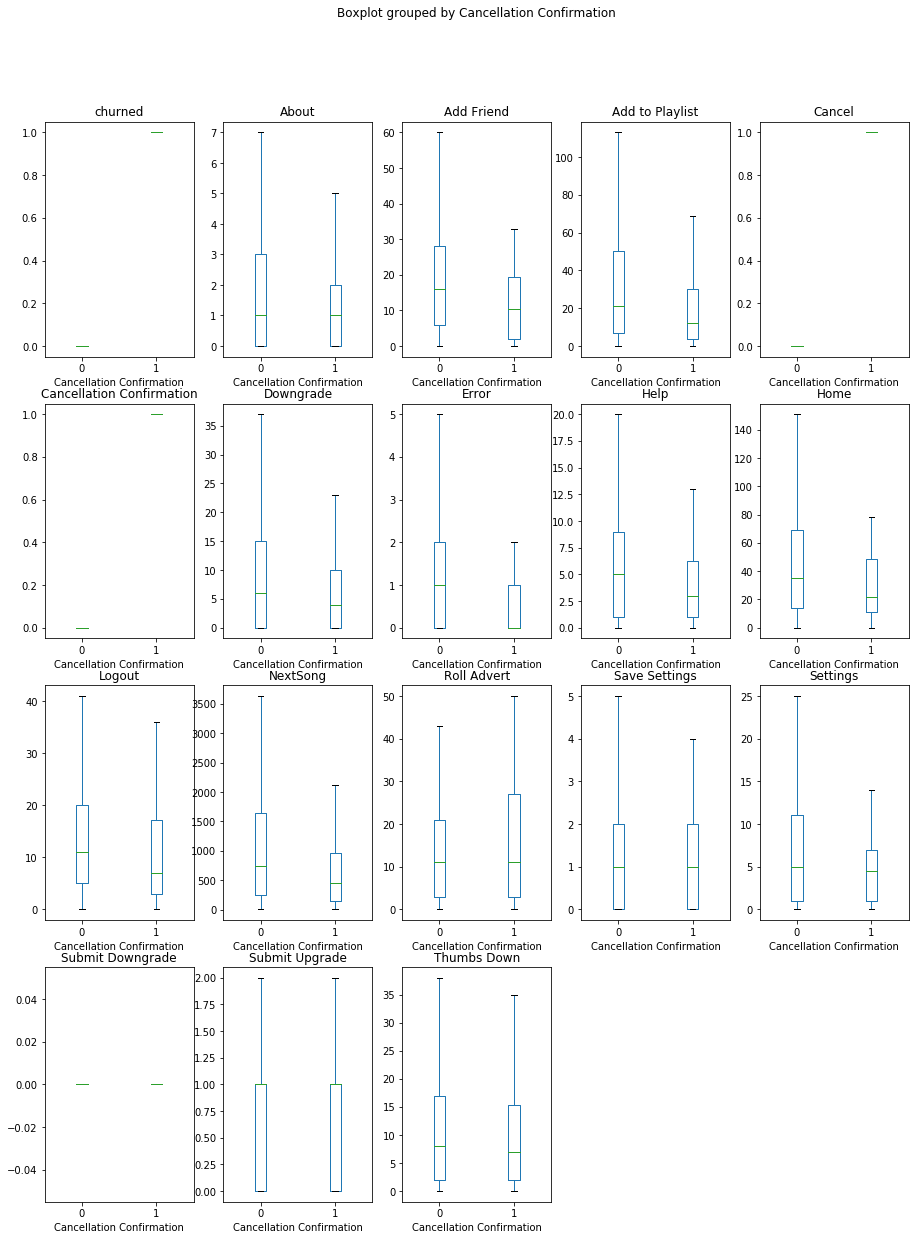

In [32]:
# Boxplot grouped by Cancellation Confirmation
fig= ml.figure(figsize = (15, 20))
for i in range(1,19):
    ax = fig.add_subplot(4, 5, i)
    df_page.boxplot(df_page.columns[i].format(), ax=ax,  by='Cancellation Confirmation', grid=False, showfliers=False);

From above boxplots, we can see difference in between the two groups of churned and non-churned users.Generally, churned users have added less friends, added lesser songs to playlist, witnessed lesser errors which could be due to lesser engagement, given lesser thumbs up, thumbs down , asked for less help and listened to lesser songs. We can therefore utilise these observations when creating features for our model.

In [33]:
# time spent by users of both groups listening to songs
user_log_valid.where(user_log_valid["page"] == "NextSong").select("userId","churned","length")\
                        .groupby("userId","churned").agg({"length":"sum"})\
                        .groupby("churned")\
                        .agg({"sum(length)":"avg"})\
                        .withColumnRenamed("avg(sum(length))", "Average_time").show()

+-------+------------------+
|churned|      Average_time|
+-------+------------------+
|      0|276166.93746780336|
|      1| 174014.2685513462|
+-------+------------------+



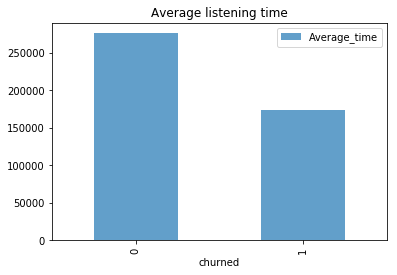

In [34]:
f1 = user_log_valid.where(user_log_valid["page"] == "NextSong").select("userId","churned","length")\
                        .groupby("userId","churned").agg({"length":"sum"})\
                        .groupby("churned")\
                        .agg({"sum(length)":"avg"})\
                        .withColumnRenamed("avg(sum(length))", "Average_time").toPandas()
f1.plot(kind='bar', y='Average_time', x='churned',title="Average listening time", alpha=0.7)

The average listening time of churned users is less than non-churned users. This can be considered as a a feature

In [35]:
# number of thumbs up
user_log_valid.select("userId", "page","churned").where(user_log_valid["page"]=="Thumbs Up")\
                .groupby("userId","churned").agg({"page":"count"}) \
                .groupby("churned")\
                .agg({"count(page)":"avg"})\
                .withColumnRenamed("avg(count(page))","Average_num_Thumbs_up").show()

+-------+---------------------+
|churned|Average_num_Thumbs_up|
+-------+---------------------+
|      0|    62.89411764705882|
|      1|                37.18|
+-------+---------------------+



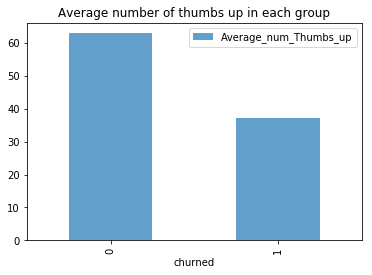

In [36]:
f2 = user_log_valid.select("userId", "page","churned").where(user_log_valid["page"]=="Thumbs Up")\
                .groupby("userId","churned").agg({"page":"count"}) \
                .groupby("churned")\
                .agg({"count(page)":"avg"})\
                .withColumnRenamed("avg(count(page))","Average_num_Thumbs_up").toPandas()
f2.plot(kind='bar',x='churned', y='Average_num_Thumbs_up', title='Average number of thumbs up in each group', alpha=0.7)

The average number of thumbs up given by a churned user is significantly less that of a non-churned user.

In [37]:
# number of thumbs down
user_log_valid.select("userId", "page","churned").where(user_log_valid["page"]=="Thumbs Down")\
                .groupby("userId","churned").agg({"page":"count"}) \
                .groupby("churned")\
                .agg({"count(page)":"avg"})\
                .withColumnRenamed("avg(count(page))", "Average_num_Thumbs_down").show()

+-------+-----------------------+
|churned|Average_num_Thumbs_down|
+-------+-----------------------+
|      0|     13.225806451612904|
|      1|     10.333333333333334|
+-------+-----------------------+



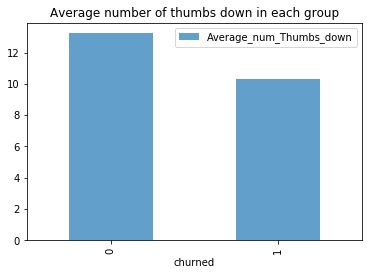

In [38]:
f3= user_log_valid.select("userId", "page","churned").where(user_log_valid["page"]=="Thumbs Down")\
                .groupby("userId","churned").agg({"page":"count"}) \
                .groupby("churned")\
                .agg({"count(page)":"avg"})\
                .withColumnRenamed("avg(count(page))", "Average_num_Thumbs_down").toPandas()
f3.plot(kind='bar',x='churned', y='Average_num_Thumbs_down', title='Average number of thumbs down in each group', alpha=0.7)

The difference in average number of thumbs down given by churned and non-churned users is not very significant. But, still we can use it as a fetaure to better capture churn pattern.

In [39]:
# number of songs played
user_log_valid.select("userId","song","churned")\
                .groupby("userId","churned").agg({"song":"count"})\
                .groupby("churned")\
                .agg({"count(song)":"avg"})\
                .withColumnRenamed("avg(count(song))", "average_num_songs").show()

+-------+------------------+
|churned| average_num_songs|
+-------+------------------+
|      0|1108.1734104046243|
|      1| 699.8846153846154|
+-------+------------------+



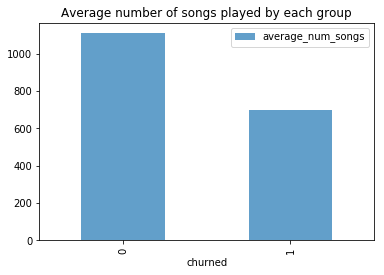

In [40]:
f4= user_log_valid.select("userId","song","churned")\
                .groupby("userId","churned").agg({"song":"count"})\
                .groupby("churned")\
                .agg({"count(song)":"avg"})\
                .withColumnRenamed("avg(count(song))", "average_num_songs").toPandas()
f4.plot(kind='bar',x='churned', y='average_num_songs', title='Average number of songs played by each group', alpha=0.7)

The average number of songs played by a churned user is significantly less than non-churned users. This is an imnportant feature to consider.

In [41]:
# Number of songs listened per session per user
user_log_valid.filter(user_log_valid["page"]=="NextSong")\
                .groupby("userId","sessionId").agg({"sessionId":"count"})\
                .groupby("userId")\
                .agg({"count(sessionId)":"avg"})\
                .withColumnRenamed("avg(count(sessionId))","songsPerSession").show()
                

+------+------------------+
|userId|   songsPerSession|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
|   125|               8.0|
|    51|             211.1|
|   124|145.67857142857142|
|     7|21.428571428571427|
|    54| 81.17142857142858|
|    15|136.71428571428572|
|   155|136.66666666666666|
|100014|42.833333333333336|
|   132|             120.5|
|   154|              28.0|
|   101|             179.7|
|    11|           40.4375|
|300017|59.540983606557376|
|   138|             138.0|
|    29| 89.05882352941177|
|    69|             125.0|
|100021|              46.0|
|    42| 87.14634146341463|
+------+------------------+
only showing top 20 rows



Number of songs played per session for a user will also help us in prediction.

In [42]:
# number of days since registration
user_log_valid.select("userId","churned","registration","ts")\
                .withColumn("timeSinceReg", (user_log_valid["ts"]-user_log_valid["registration"]))\
                .groupby("userId", "churned")\
                .agg({"timeSinceReg": "max"})\
                .withColumnRenamed("max(timeSinceReg)","active_days")\
                .select("userId","churned",(col("active_days")/1000/3600/24).alias("active_days"))\
                .groupby("churned")\
                .agg({"active_days":"avg"}).withColumnRenamed("avg(active_days)", "avg_num_of_active_days").show()

+-------+----------------------+
|churned|avg_num_of_active_days|
+-------+----------------------+
|      0|     86.62061938021834|
|      1|     57.30599292200856|
+-------+----------------------+



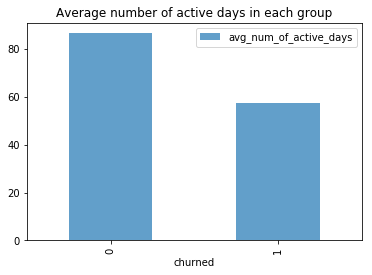

In [43]:
f6 = user_log_valid.select("userId","churned","registration","ts")\
                .withColumn("timeSinceReg", (user_log_valid["ts"]-user_log_valid["registration"]))\
                .groupby("userId", "churned")\
                .agg({"timeSinceReg": "max"})\
                .withColumnRenamed("max(timeSinceReg)","active_days")\
                .select("userId","churned",(col("active_days")/1000/3600/24).alias("active_days"))\
                .groupby("churned")\
                .agg({"active_days":"avg"}).withColumnRenamed("avg(active_days)", "avg_num_of_active_days").toPandas()
f6.plot(kind='bar',x='churned', y='avg_num_of_active_days', title='Average number of active days in each group', alpha=0.7)

 A churned user spends lesser number of days on an average. This feature should also prove to be useful.

In [44]:
# number of added friends
user_log_valid.select("userId", "page","churned")\
        .where(user_log_valid["page"]=="Add Friend")\
        .groupby("userId","churned")\
        .agg({"page": "count"})\
        .groupby("churned")\
        .agg({"count(page)":"avg"}).withColumnRenamed("avg(count(page))", "avg_num_of_added_friends")\
        .show()

+-------+------------------------+
|churned|avg_num_of_added_friends|
+-------+------------------------+
|      0|       22.47530864197531|
|      1|      14.454545454545455|
+-------+------------------------+



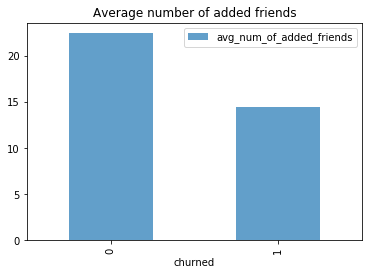

In [45]:
f7 = user_log_valid.select("userId", "page","churned")\
        .where(user_log_valid["page"]=="Add Friend")\
        .groupby("userId","churned")\
        .agg({"page": "count"})\
        .groupby("churned")\
        .agg({"count(page)":"avg"}).withColumnRenamed("avg(count(page))", "avg_num_of_added_friends").toPandas()
f7.plot(kind='bar',x='churned', y='avg_num_of_added_friends', title='Average number of added friends', alpha=0.7)

A churned user add lesser friends too.

In [46]:
user_log_valid.groupby("userId","churned").count().show()

+------+-------+-----+
|userId|churned|count|
+------+-------+-----+
|100010|      0|  381|
|200002|      0|  474|
|   125|      1|   11|
|   124|      0| 4825|
|    51|      1| 2464|
|     7|      0|  201|
|    15|      0| 2278|
|    54|      1| 3437|
|   155|      0| 1002|
|100014|      1|  310|
|   132|      0| 2304|
|   154|      0|  118|
|   101|      1| 2149|
|    11|      0|  848|
|   138|      0| 2469|
|300017|      0| 4428|
|100021|      1|  319|
|    29|      1| 3603|
|    69|      0| 1342|
|   112|      0|  292|
+------+-------+-----+
only showing top 20 rows



# Feature Engineering

In [47]:
# Feature 1
feat1 = user_log_valid.where(user_log_valid["page"] == "NextSong").select("userId","length")\
                        .groupby("userId").agg({"length":"sum"}).withColumnRenamed("sum(length)","playTime")

In [48]:
feat1.show()

+------+------------------+
|userId|          playTime|
+------+------------------+
|100010| 66940.89735000003|
|200002| 94008.87593999993|
|   125|2089.1131000000005|
|    51| 523275.8428000004|
|   124|1012312.0927899999|
|     7| 38034.08710000002|
|    54| 711344.9195400011|
|    15|477307.60581000015|
|   155|       198779.2919|
|   132| 483118.9038399997|
|   154|20660.023910000007|
|100014| 67703.47208000004|
|   101| 447464.0146699989|
|    11|159669.96303999983|
|   138| 512449.8827599989|
|300017| 897406.9802100015|
|    29| 754517.5625700009|
|    69| 286064.0256399999|
|100021| 57633.17563999999|
|    42| 881792.9661300007|
+------+------------------+
only showing top 20 rows



In [49]:
# Feature 2
feat2 = user_log_valid.select("userId", "page").where(user_log_valid["page"]=="Thumbs Up")\
                .groupby("userId").agg({"page":"count"}).withColumnRenamed("count(page)","numThumbsUp")
feat2.show()

+------+-----------+
|userId|numThumbsUp|
+------+-----------+
|100010|         17|
|200002|         21|
|    51|        100|
|   124|        171|
|     7|          7|
|    54|        163|
|    15|         81|
|   155|         58|
|   132|         96|
|   154|         11|
|100014|         17|
|   101|         86|
|    11|         40|
|   138|         95|
|300017|        303|
|    29|        154|
|    69|         72|
|100021|         11|
|    42|        166|
|   112|          9|
+------+-----------+
only showing top 20 rows



In [50]:
# Feature 3
feat3 = user_log_valid.select("userId", "page").where(user_log_valid["page"]=="Thumbs Down")\
                .groupby("userId").agg({"page":"count"}).withColumnRenamed("count(page)", "numThumbsDown")
feat3.show()

+------+-------------+
|userId|numThumbsDown|
+------+-------------+
|100010|            5|
|200002|            6|
|    51|           21|
|   124|           41|
|     7|            1|
|    15|           14|
|    54|           29|
|   155|            3|
|   132|           17|
|100014|            3|
|   101|           16|
|    11|            9|
|   138|           24|
|300017|           28|
|    29|           22|
|    69|            9|
|100021|            5|
|    42|           25|
|   112|            3|
|    73|            7|
+------+-------------+
only showing top 20 rows



In [51]:
# Feature 4
feat4 = user_log_valid.select("userId","song")\
                .groupby("userId").agg({"song":"count"}).withColumnRenamed("count(song)", "numSongs")
feat4.show()

+------+--------+
|userId|numSongs|
+------+--------+
|100010|     275|
|200002|     387|
|   125|       8|
|    51|    2111|
|   124|    4079|
|     7|     150|
|    54|    2841|
|    15|    1914|
|   155|     820|
|   132|    1928|
|   154|      84|
|100014|     257|
|   101|    1797|
|    11|     647|
|   138|    2070|
|300017|    3632|
|    29|    3028|
|    69|    1125|
|100021|     230|
|    42|    3573|
+------+--------+
only showing top 20 rows



In [52]:
# Feature 5
feat5= user_log_valid.filter(user_log_valid["page"]=="NextSong")\
                .groupby("userId","sessionId").agg({"sessionId":"count"})\
                .groupby("userId")\
                .agg({"count(sessionId)":"avg"})\
                .withColumnRenamed("avg(count(sessionId))","songsPerSession")
feat5.show()

+------+------------------+
|userId|   songsPerSession|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
|   125|               8.0|
|    51|             211.1|
|   124|145.67857142857142|
|     7|21.428571428571427|
|    54| 81.17142857142858|
|    15|136.71428571428572|
|   155|136.66666666666666|
|100014|42.833333333333336|
|   132|             120.5|
|   154|              28.0|
|   101|             179.7|
|    11|           40.4375|
|300017|59.540983606557376|
|   138|             138.0|
|    29| 89.05882352941177|
|    69|             125.0|
|100021|              46.0|
|    42| 87.14634146341463|
+------+------------------+
only showing top 20 rows



In [53]:
# Feature 6
feat6 = user_log_valid.select("userId","registration","ts")\
                .withColumn("timeSinceReg", (user_log_valid["ts"]-user_log_valid["registration"]))\
                .groupby("userId")\
                .agg({"timeSinceReg": "max"})\
                .withColumnRenamed("max(timeSinceReg)","active_days")\
                .select("userId",(col("active_days")/1000/3600/24).alias("active_days"))
feat6.show()

+------+------------------+
|userId|       active_days|
+------+------------------+
|100010|  55.6436574074074|
|200002| 70.07462962962963|
|   125| 71.31688657407408|
|    51|19.455844907407407|
|   124|131.55591435185184|
|     7| 72.77818287037037|
|    54|110.75168981481481|
|    15|56.513576388888886|
|   155|23.556018518518517|
|   132|  66.8891087962963|
|   154|23.872037037037035|
|100014| 85.08340277777778|
|   101|53.965937499999995|
|    11|124.47825231481481|
|   138| 66.62668981481481|
|300017| 74.35851851851852|
|    29|60.104050925925925|
|    69| 71.42444444444445|
|100021| 64.73886574074074|
|    42| 67.11364583333334|
+------+------------------+
only showing top 20 rows



In [54]:
# Feature 7
feat7= user_log_valid.select("userId", "page")\
        .where(user_log_valid["page"]=="Add Friend")\
        .groupby("userId")\
        .agg({"page": "count"}).withColumnRenamed("count(page)","num_added_friends")
feat7.show()

+------+-----------------+
|userId|num_added_friends|
+------+-----------------+
|100010|                4|
|200002|                4|
|    51|               28|
|   124|               74|
|     7|                1|
|    54|               33|
|    15|               31|
|   155|               11|
|   132|               41|
|   154|                3|
|100014|                6|
|   101|               29|
|    11|                6|
|   138|               41|
|300017|               63|
|    29|               47|
|    69|               12|
|100021|                7|
|    42|               52|
|   112|                7|
+------+-----------------+
only showing top 20 rows



In [55]:
# UserId and churn label
churn_label = user_log_valid.select("userId","churned").dropDuplicates()
churn_label.show()

+------+-------+
|userId|churned|
+------+-------+
|100010|      0|
|200002|      0|
|   125|      1|
|   124|      0|
|    51|      1|
|     7|      0|
|    15|      0|
|    54|      1|
|   155|      0|
|100014|      1|
|   132|      0|
|   154|      0|
|   101|      1|
|    11|      0|
|   138|      0|
|300017|      0|
|100021|      1|
|    29|      1|
|    69|      0|
|   112|      0|
+------+-------+
only showing top 20 rows



# Modeling

#### Evaluation Metric

In our dataset, churned users(23%) are lesser in number than non-churned users(77%). Using accuracy as evaluation metric, will not give a good performance, because any model predicting "no-churn" will have good accuracy . 
-  Instead, I use F1 score as the evalution metric. F1 score gives a balanced score between precision and recall
-  F1 score is calculated using the formula : (2 * precision * recall)/(precision + recall)

In [56]:
# joining all features
total_features_df = feat1.join(feat2, "userId","outer" )\
                    .join(feat3, "userId","outer")\
                    .join(feat4, "userId","outer")\
                    .join(feat5, "userId","outer")\
                    .join(feat6, "userId","outer")\
                    .join(feat7, "userId","outer")\
                    .join(churn_label, "userId","outer").drop("userId").fillna(0)
total_features_df.show()

+------------------+-----------+-------------+--------+------------------+------------------+-----------------+-------+
|          playTime|numThumbsUp|numThumbsDown|numSongs|   songsPerSession|       active_days|num_added_friends|churned|
+------------------+-----------+-------------+--------+------------------+------------------+-----------------+-------+
| 66940.89735000003|         17|            5|     275|39.285714285714285|  55.6436574074074|                4|      0|
| 94008.87593999993|         21|            6|     387|              64.5| 70.07462962962963|                4|      0|
|2089.1131000000005|          0|            0|       8|               8.0| 71.31688657407408|                0|      1|
|1012312.0927899999|        171|           41|    4079|145.67857142857142|131.55591435185184|               74|      0|
| 523275.8428000004|        100|           21|    2111|             211.1|19.455844907407407|               28|      1|
| 38034.08710000002|          7|        

In [57]:
# Vector Assembler
cols= ['playTime','numThumbsUp','numThumbsDown','numSongs','songsPerSession','active_days','num_added_friends']
assembler = VectorAssembler(inputCols=cols, outputCol='Features')
total_features_df = assembler.transform(total_features_df)

In [58]:
# Standard Scaler
scaler_1= StandardScaler(inputCol='Features', outputCol='scaled_features_1', withStd=True)
scalerModel = scaler_1.fit(total_features_df)
total_features_df = scalerModel.transform(total_features_df) 

In [59]:
total_features_df.take(2)

[Row(playTime=66940.89735000003, numThumbsUp=17, numThumbsDown=5, numSongs=275, songsPerSession=39.285714285714285, active_days=55.6436574074074, num_added_friends=4, churned=0, Features=DenseVector([66940.8974, 17.0, 5.0, 275.0, 39.2857, 55.6437, 4.0]), scaled_features_1=DenseVector([0.2431, 0.2596, 0.3823, 0.2489, 0.9219, 1.4775, 0.1943])),
 Row(playTime=94008.87593999993, numThumbsUp=21, numThumbsDown=6, numSongs=387, songsPerSession=64.5, active_days=70.07462962962963, num_added_friends=4, churned=0, Features=DenseVector([94008.8759, 21.0, 6.0, 387.0, 64.5, 70.0746, 4.0]), scaled_features_1=DenseVector([0.3414, 0.3207, 0.4588, 0.3502, 1.5135, 1.8606, 0.1943]))]

In [60]:
# selecting the two required columns for modelling
total_features_df = total_features_df.select(col('scaled_features_1').alias('features'), col('churned').alias('label'))
total_features_df

DataFrame[features: vector, label: bigint]

In [61]:
# Split the data into train and validation set
train, validation = total_features_df.randomSplit([0.9, 0.1], seed=42)

#### Logistic Regression

In [62]:
# initialize classifier
lr = LogisticRegression(maxIter=10)

# evaluator
evaluator_1 = MulticlassClassificationEvaluator(metricName='f1')

# paramGrid
paramGrid = ParamGridBuilder() \
    .build()

crossval_lr = CrossValidator(estimator=lr,
                          evaluator=evaluator_1, 
                          estimatorParamMaps=paramGrid,
                          numFolds=3)

In [93]:
cvModel_lr = crossval_lr.fit(train)
cvModel_lr.avgMetrics

[0.7686243093713554]

In [94]:
results = cvModel_lr.transform(validation)
evaluator = evaluator= MulticlassClassificationEvaluator(predictionCol='prediction')
print("F1 score of Logistic Regression Model is: ")
print(evaluator.evaluate(results_lr, {evaluator.metricName: "f1"}))
print("Accuracy of Logistic Regression Model is: ")
print(evaluator.evaluate(results_lr, {evaluator.metricName: "accuracy"}))

F1 score of Logistic Regression Model is: 
0.7666666666666667
Accuracy of Logistic Regression Model is: 
0.8125


#### Decision tree classifier

In [67]:
# initialize classifier
dtc = DecisionTreeClassifier()

# evaluator
evaluator_2 = MulticlassClassificationEvaluator(metricName='f1')

# paramGrid
paramGrid = ParamGridBuilder() \
    .build()

crossval_dtc = CrossValidator(estimator=dtc,
                          evaluator=evaluator_2, 
                          estimatorParamMaps=paramGrid,
                          numFolds=3)

In [99]:
cvModel_dtc = crossval_dtc.fit(train)
cvModel_dtc.avgMetrics

[0.6713370302465589]

In [100]:
results_dtc = cvModel_dtc.transform(validation)
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')
print("F1 score of Decision Tree Classifier Model is: ")
print(evaluator.evaluate(results_dtc, {evaluator.metricName: "f1"}))
print("Accuracy of Decision Tree Classifier Model is: ")
print(evaluator.evaluate(results_dtc, {evaluator.metricName: "accuracy"}))

F1 score of Decision Tree Classifier Model is: 
0.6428571428571428
Accuracy of Decision Tree Classifier Model is: 
0.75


#### Random Forest Classifier Model

In [68]:
# initialize classifier
rfc = RandomForestClassifier()

# evaluator
evaluator_3 = MulticlassClassificationEvaluator(metricName='f1')

# paramGrid
paramGrid = ParamGridBuilder() \
    .build()

crossval_rfc = CrossValidator(estimator=rfc,
                          evaluator=evaluator_3, 
                          estimatorParamMaps=paramGrid,
                          numFolds=3)

In [102]:
cvModel_rfc = crossval_rfc.fit(train)
cvModel_rfc.avgMetrics

[0.746156191384082]

In [103]:
results_rfc = cvModel_rfc.transform(validation)
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')
print("F1 score of Random Forest Classifier Model is: ")
print(evaluator.evaluate(results_rfc, {evaluator.metricName: "f1"}))
print("Accuracy of Random Forest Classifier Model is: ")
print(evaluator.evaluate(results_rfc, {evaluator.metricName: "accuracy"}))

F1 score of Random Forest Classifier Model is: 
0.8589743589743589
Accuracy of Random Forest Classifier Model is: 
0.875


#### Summary of all models used

I used 3 models to train on the given data.
-  The Logistic Regression model gave an accuarcy of 0.8125 and F1 score of 0.766
-  The Decision Tree classifier model gave an accuracy of 0.75 and F1 score of 0.642
-  The Random Forest Classifier gave an accuracy of 0.87 and F1 score of 0.858
The best performing model among them is Random Forest Classifier. I choose it and conduct grid search to fine tune the model.

#### Refinement and Hyperparameter tuning

I use 3 parameters for tuning the Random Forest model : maxDepth, minInstancesPerNode and numTress

In [69]:
# Random Forest Classifier Model

paramGrid_rfc_final= ParamGridBuilder()\
    .addGrid(rfc.maxDepth, [5, 8])\
    .addGrid(rfc.minInstancesPerNode,[1,4])\
    .addGrid(rfc.numTrees,[20,40])\
    .build()
crossval_rfc_final = CrossValidator(estimator=rfc,
                          estimatorParamMaps=paramGrid_rfc_final,
                          evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                          numFolds=3)

In [70]:
cvModel_rfc_final = crossval_rfc_final.fit(train)

In [104]:
# The best parameters for the model are
print("maxDepth", cvModel_rfc_final.bestModel._java_obj.getMaxDepth())
print("minInstancesPerNode", cvModel_rfc_final.bestModel._java_obj.getMinInstancesPerNode())
print("numTrees", cvModel_rfc_final.bestModel._java_obj.getNumTrees())

maxDepth 5
minInstancesPerNode 1
numTrees 20


#### Final Model Metrics

In [71]:
results_rfc_final = cvModel_rfc_final.transform(validation)
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')
print("F1 score is: ")
print(evaluator.evaluate(results_rfc_final, {evaluator.metricName: "f1"}))
print("Accuracy is: ")
print(evaluator.evaluate(results_rfc_final, {evaluator.metricName: "accuracy"}))

F1 score is: 
0.8589743589743589
Accuracy is: 
0.875


#### Feature Importance of Random Forest Classifier model

In [96]:
#  Bar Chart displaying importance of various features
feature_names = ['playTime','numThumbsUp','numThumbsDown','numSongs','songsPerSession','active_days','num_added_friends']
feature_coef = list(cvModel_rfc_final.bestModel.featureImportances.values)
data=[go.Bar(
        x= feature_names,
        y= feature_coef
    )]
layout = go.Layout(
    title='Random Forest Classifier Model Feature Importance')
figure = go.Figure(data=data,layout=layout)
plt.iplot(figure)

From the above plot, we can see that number of active days is contributing the most . This makes sense also, because the more number of days a customer stays is an indication that the cusotmer is happy using the product and less likely to churn

# Conclusion
The best performing model, out of the 3, is the RandomForestClassifier model which achieved an F1 score of 0.8589. This model can be used by the company to flag users who are more likely to churn and thus ,woo them with special offers and discounts , in order to retain them.
The above analysis can be more robust when we use the full data. I have used the small subset of data here. Moreover, adding more feauture will further improve our analysis.
I liked all aspects of this project, data preprocessing, exploratory analysis, feature engineering, modelling and then fine tuning the model.Doing this project , helped learn the basics of PySpark. A lot can be improved in this project, but for now I think I have accomplished all the requirements.
Thanks for reading !